In [1]:
import sys
sys.path.insert(0, "../..")
from pathlib import Path

In [2]:
from src.datasets import get_arabic
from src.settings import presets

In [3]:
presets

Settings(datadir=PosixPath('/workspaces/MLopdracht/data/raw'), testurl=HttpUrl('https://archive.ics.uci.edu/ml/machine-learning-databases/00195/Test_Arabic_Digit.txt', ), trainurl=HttpUrl('https://archive.ics.uci.edu/ml/machine-learning-databases/00195/Train_Arabic_Digit.txt', ), testfile=PosixPath('ArabicTest.txt'), trainfile=PosixPath('ArabicTrain.txt'), modeldir=PosixPath('/workspaces/MLopdracht/models'), logdir=PosixPath('/workspaces/MLopdracht/logs'), modelname='model.pt', batchsize=64)

In [4]:
trainstreamer, teststreamer = get_arabic(presets)

2023-06-05 08:16:50.073 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTrain.txt already exists, skip download
2023-06-05 08:16:50.076 | INFO     | src.data_tools:get_file:74 - File /workspaces/MLopdracht/data/raw/ArabicTest.txt already exists, skip download
2023-06-05 08:16:50.079 | INFO     | src.datasets:get_arabic:33 - Loading data from /workspaces/MLopdracht/data/raw/ArabicTrain.txt and /workspaces/MLopdracht/data/raw/ArabicTest.txt
2023-06-05 08:16:50.936 | INFO     | src.datasets:get_arabic:49 - Returning trainstreamer, teststreamer


In [37]:
x, y = next(iter(trainstreamer.stream()))
x.shape, y.shape

(torch.Size([64, 56, 13]), torch.Size([64]))

In [38]:
labels = trainstreamer.dataset.get_labels()
unique_set = set(labels)
unique_set, len(unique_set)

({'0f',
  '0m',
  '1f',
  '1m',
  '2f',
  '2m',
  '3f',
  '3m',
  '4f',
  '4m',
  '5f',
  '5m',
  '6f',
  '6m',
  '7f',
  '7m',
  '8f',
  '8m',
  '9f',
  '9m'},
 20)

In [5]:
from src import datasets
from src.models import rnn_models, metrics, train_model
from src.settings import SearchSpace, TrainerSettings, presets
from pathlib import Path

config = SearchSpace(
    input_size=13,
    output_size=20,
    hidden_size=26,
    dropout=0.1,   
    num_layers=3,     
    tune_dir=Path("models/ray").resolve(),
    data_dir=presets.datadir.resolve()
)
model = rnn_models.LSTMmodel(config.dict())

/workspaces/MLopdracht/.venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [29]:
from src import datasets
from src.models import rnn_models, metrics, train_model
from src.settings import SearchSpaceAttention, TrainerSettings, presets
from pathlib import Path

config = SearchSpaceAttention(
    input_size=13,
    output_size=20, 
    size_and_heads='120_30',
    dropout=0.02319741641270231,   
    num_layers=4,     
    tune_dir=Path("models/ray").resolve(),
    data_dir=presets.datadir.resolve(),
    use_mean=False
)
model = rnn_models.GRUAttentionAarabic(config.dict())

In [30]:
from torchsummary import summary
summary(model, input_size=(1, 13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 1, 120], [-1, 2, 120]]               0
MultiheadAttention-2  [[-1, 1, 120], [-1, 1, 1]]               0
            Linear-3                   [-1, 20]           2,420
Total params: 2,420
Trainable params: 2,420
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [31]:
from graphviz import Digraph
import torch
from torch import nn
dot = Digraph(comment='TransformerAarabic Model')

In [32]:
for name, module in model.named_modules():
    if isinstance(module, nn.Module):
        dot.node(name, str(module))

In [33]:
for name, module in model.named_modules():
    if isinstance(module, nn.Module):
        for child_name, child_module in module.named_modules():
            if isinstance(child_module, nn.Module):
                dot.edge(name, child_name)

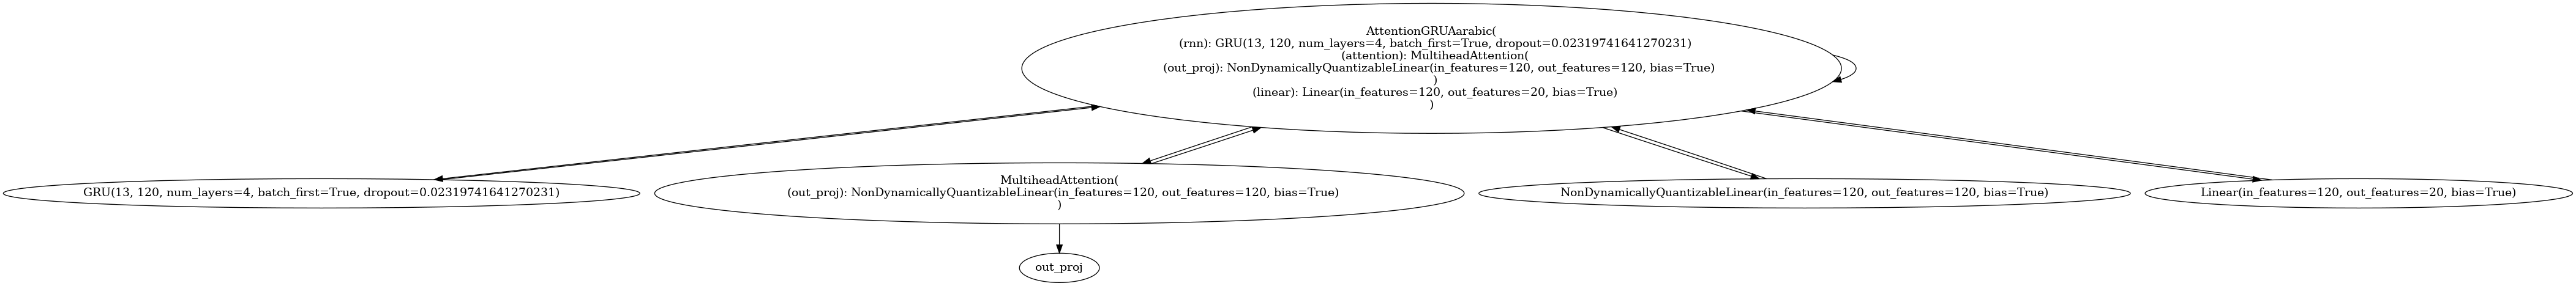

In [34]:
dot.format = 'png'
dot.render('transformer_model_graph', view=False)

# Open the image file
image = Image.open('transformer_model_graph.png')

# Display the image
display.display(image)

In [35]:
import sys
sys.path.insert(0, "../..")

import torch
import torch.nn as nn
import torch.optim as optim
from src.models import metrics

optimizer = optim.Adam
loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

In [39]:
yhat = model(x)
y, yhat, accuracy(y, yhat)


(tensor([ 4,  6,  5, 15, 10,  1,  5, 18, 10,  7,  6, 11, 13, 19, 13,  9, 10,  2,
          6, 15, 16,  4, 11,  5,  5, 13, 19, 14, 10, 18,  1,  9, 19, 15,  2,  7,
          6, 11, 12,  7, 10, 18,  7, 11,  3, 19, 13,  7, 12,  7,  0,  7, 11,  9,
         17,  3,  7, 11, 15, 14,  8, 14, 17, 10]),
 tensor([[-0.0449, -0.0164, -0.0922,  ...,  0.0089,  0.0319, -0.0962],
         [-0.0399, -0.0159, -0.0930,  ...,  0.0149,  0.0270, -0.0952],
         [-0.0384, -0.0108, -0.1017,  ...,  0.0199,  0.0299, -0.0914],
         ...,
         [-0.0411, -0.0171, -0.0889,  ...,  0.0097,  0.0282, -0.0971],
         [-0.0402, -0.0150, -0.0918,  ...,  0.0148,  0.0293, -0.0967],
         [-0.0366, -0.0157, -0.0944,  ...,  0.0177,  0.0272, -0.0954]],
        grad_fn=<AddmmBackward0>),
 tensor(0.0938))

In [40]:
loss = loss_fn(yhat, y)

In [41]:
loss

tensor(2.9932, grad_fn=<NllLossBackward0>)

In [42]:
tune_dir = Path("../../models/ray").resolve()
tune_dir.exists()
tune_dir

PosixPath('/workspaces/MLopdracht/models/ray')

In [96]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)

analysis = ExperimentAnalysis(tune_dir)

2023-06-05 13:01:50,388	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.
2023-06-05 13:01:50,492	INFO experiment_analysis.py:812 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [63]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'time_this_iter_s',
       'done', 'timesteps_total', 'episodes_total', 'training_iteration',
       'date', 'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/input_size', 'config/output_size', 'config/tune_dir',
       'config/data_dir', 'config/dropout', 'config/num_layers',
       'config/use_mean', 'config/size_and_heads', 'config/hidden_size',
       'config/num_heads', 'config/mlflow_dir',
       'config/num_transformer_layers', 'config/dropout_attention'],
      dtype='object')

In [86]:
plot = analysis.results_df
select = ["Accuracy", 'train_loss', 'test_loss', "config/hidden_size", "config/dropout", "config/num_layers", 'config/use_mean', 'iterations']
p = plot[select].reset_index().dropna()

In [87]:
p.sort_values("Accuracy", inplace=True)

In [88]:
import plotly.express as px
px.parallel_coordinates(p, color="Accuracy")

In [89]:
bla = analysis.get_best_trial(metric="test_loss", mode="min")
bla

train_0b298ea3

In [90]:
p[-10:]

,trial_id,Accuracy,train_loss,test_loss,config/hidden_size,config/dropout,config/num_layers,config/use_mean,iterations
80,c76546fe,0.049632,3.009039,3.002077,108.0,0.027943,4.0,False,8.0
64,af47a360,0.113971,2.804604,2.566119,87.0,0.090782,2.0,True,0.0
61,a09230ef,0.137868,2.797157,2.569793,94.0,0.070543,2.0,True,0.0
104,ff9b371e,0.221507,2.480183,2.336213,35.0,0.211048,2.0,True,1.0
97,f5c7286b,0.892923,0.104530,0.548379,33.0,0.231431,3.0,False,49.0
74,bfedba38,0.935662,0.059835,0.246835,120.0,0.042974,4.0,False,5.0
105,ffe72673,0.943015,0.159162,0.324161,120.0,0.027017,4.0,False,99.0
82,ccd2f2ef,0.954504,0.000261,0.233226,127.0,0.154536,2.0,False,49.0
101,fbdb0c4d,0.957261,0.019724,0.213766,120.0,0.123935,4.0,False,49.0
4,0b298ea3,0.972886,0.000042,0.105281,120.0,0.023197,4.0,False,49.0


In [99]:
best_trial = analysis.get_best_config(metric="Accuracy", mode="max")


In [103]:
best_trial

{'input_size': 13,
 'output_size': 20,
 'tune_dir': PosixPath('/workspaces/MLopdracht/models/ray'),
 'data_dir': PosixPath('/workspaces/MLopdracht/data/raw'),
 'dropout': 0.02319741641270231,
 'num_layers': 4,
 'use_mean': False,
 'size_and_heads': '120_30'}

In [112]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import set_config

set_config(display='diagram')

# Define the pipeline steps
preprocessor = StandardScaler()
classifier = SVC()
# accuracy = metrics.Accuracy()
pipeline = make_pipeline(model)

# Visualize the pipeline
pipeline

Pipeline(steps=[('attentiongruaarabic',
                 AttentionGRUAarabic(
  (rnn): GRU(13, 120, num_layers=4, batch_first=True, dropout=0.02319741641270231)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
  )
  (linear): Linear(in_features=120, out_features=20, bias=True)
))])

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import set_config
from sklearn import set_config, compose
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris

set_config(display='diagram')

# Define the pipeline steps
preprocessor = StandardScaler()
classifier = SVC()

# Create the pipeline
# pipeline = make_pipeline(preprocessor, model, classifier)
pipeline = make_pipeline(preprocessor, 'passthrough', classifier)

# Load example data
X, y = load_iris(return_X_y=True)

# Fit the pipeline
pipeline.fit(X, y)

# Save the pipeline diagram as an image
compose.plot_pipeline(pipeline, "pipeline.png")

AttributeError: module 'sklearn.compose' has no attribute 'plot_pipeline'

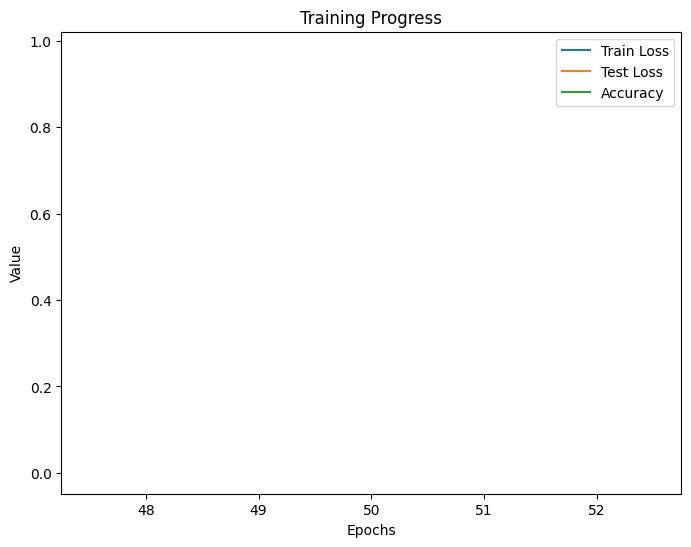

In [110]:
import matplotlib.pyplot as plt

# Extract the metrics from the analysis
best_trial = analysis.get_best_trial("test_loss", mode="min")
# results = best_trial["last_result"]
train_loss = best_trial.last_result["train_loss"]
test_loss = best_trial.last_result["test_loss"]
accuracy = best_trial.last_result["Accuracy"]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# epochs = range(len(train_loss))
plt.plot(50, train_loss, label="Train Loss")
plt.plot(50, test_loss, label="Test Loss")
plt.plot(50, accuracy, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.show()